In [392]:
import os.path as osp
import os
from pylgmath import se3op, so3op
import matplotlib.pyplot as plt
from bisect import bisect_left
from estimate_qc import *

In [487]:
# root = '/workspace/raid/krb/boreas/boreas-2021-09-02-11-42/'
# debug_path = '/home/krb/ASRL/temp/steam_icp/boreas_velodyne/steamlio/boreas-2021-09-02-11-42_debug.txt'

sensor = 'radar'

root = '/home/asrl/boreas_docker_local/boreas-2021-09-02-11-42/'
debug_path = '/home/asrl/ASRL/temp/steam_icp/boreas_navtech/steamrio/boreas-2021-09-02-11-42_debug.txt'

# root = '/workspace/data1/boreas-2021-09-02-11-42/'
# debug_path = '/home/asrl/ASRL/temp/steam_icp/boreas_velodyne/steamlio/boreas-2021-09-02-11-42_debug.txt'

# root = '/workspace/hdd0/boreas-2022-08-05-12-59/'

# root = '/workspace/data1/simulation/'
# debug_path = '/home/asrl/ASRL/temp/steam_icp/boreas_velodyne/steamlio/simulation_debug.txt'

# root = '/workspace/data2/2023_02_15_1/'

In [394]:
def get_applanix_data_at_time(time, gps_times, gps_lines):

    idx = bisect_left(gps_times, time)
    if idx >= len(gps_times):
        idx = len(gps_times) - 1
    d = abs(gps_times[idx] - time)
    if gps_times[idx] < time and idx < len(gps_times) - 1:
        if abs(gps_times[idx + 1] - time) < d:
            idx += 1
    elif gps_times[idx] > time and idx > 0:
        if abs(gps_times[idx - 1] - time) < d:
            idx -= 1

    closest = idx

    def _parse(gps_line):
        return [float(x) for x in gps_line.split(',')]

    gt_time = gps_times[closest]

    def _interpolate(lower, upper, t):
        assert(len(lower) == len(upper))
        tlow = lower[0]
        tupp = upper[0]
        assert(tlow < t and t < tupp)
        delta = tupp - tlow
        if delta == 0:
            return lower
        ratio = (t - tlow) / delta
        out = []
        for low, upp in zip(lower, upper):
            out.append(low + (upp - low) * ratio)
        out[0] = t
        return out

    line = _parse(gps_lines[closest])
    if gt_time < time:
        if closest == len(gps_lines) - 1:
            return line
        line_lower = line
        line_upper = _parse(gps_lines[closest + 1])
        return _interpolate(line_lower, line_upper, time)
    elif gt_time > time:
        if closest == 0:
            return line
        line_lower = _parse(gps_lines[closest - 1])
        line_upper = line
        return _interpolate(line_lower, line_upper, time)
    elif gt_time == time:
        return line

# Adjust orientation and translation from T_enu_applanix --> T_enu_sensor
def adjust_pose_to_sensor(line, T_applanix_sensor):
    T_enu_applanix = np.identity(4, dtype=np.float64)
    T_enu_applanix[0:3, 0:3] = yawPitchRollToRot(line[9], line[8], line[7])  # we read C_enu_applanix
    T_enu_applanix[0, 3] = line[1]
    T_enu_applanix[1, 3] = line[2]
    T_enu_applanix[2, 3] = line[3]
    T_enu_sensor = np.matmul(T_enu_applanix, T_applanix_sensor)
    line[1] = T_enu_sensor[0, 3]
    line[2] = T_enu_sensor[1, 3]
    line[3] = T_enu_sensor[2, 3]
    y, p, r = rotToYawPitchRoll(T_enu_sensor[:3, :3])  # we write y, p, r of C_enu_sensor
    line[7] = r
    line[8] = p
    line[9] = y

    adT_sensor_applanix = Transformation(T_ba=T_applanix_sensor).inverse().adjoint()
    varpi_applanix = np.zeros(6, dtype=np.float64)
    vbar = np.array([line[4], line[5], line[6]], dtype=np.float64)  # in enu
    varpi_applanix[:3] = np.matmul(T_enu_applanix[:3, :3].T, vbar.reshape(3, 1)).squeeze()  # rotate from enu to applanix
    varpi_applanix[3:] = np.array([line[12], line[11], line[10]], dtype=np.float64)     # angular already in applanix
    varpi_sensor = np.matmul(adT_sensor_applanix, varpi_applanix.reshape(6, 1)).squeeze()
    line[4], line[5], line[6] = np.matmul(T_enu_sensor[:3, :3], varpi_sensor[:3].reshape(3, 1)).squeeze()   # rotate back to enu
    line[12], line[11], line[10] = varpi_sensor[3:]     # angular should already be in sensor frame
    return line

def rotToYawPitchRoll(C, eps = 1e-15):
    i = 2
    j = 1
    k = 0
    c_y = np.sqrt(C[i, i]**2 + C[j, i]**2)
    if c_y > eps:
        r = np.arctan2(C[j, i], C[i, i])
        p = np.arctan2(-C[k, i], c_y)
        y = np.arctan2(C[k, j], C[k, k])
    else:
        r = 0
        p = np.arctan2(-C[k, i], c_y)
        y = np.arctan2(-C[j, k], C[j, j])

    return y, p, r

In [395]:
gps_file = osp.join(root, 'applanix', 'gps_post_process.csv')
with open(gps_file, 'r') as gf:
    header = gf.readline()
    gps_lines = gf.readlines()
    gps_times = []
    for line in gps_lines:
        gps_times.append(float(line.split(',')[0]))

In [396]:
print(gps_times[-1])

1638110238.2318811


## Ground Truth

In [496]:
lpath = osp.join(root, sensor)
sensor_files = []
if osp.exists(lpath):
    sensor_files = sorted([f for f in os.listdir(lpath) if osp.isfile(osp.join(lpath, f))])

T_applanix_lidar = np.loadtxt(osp.join(root, 'calib', 'T_applanix_lidar.txt'), dtype=np.float64)
zup2zdown = np.array([1, 0, 0, 0, 0, -1, 0, 0, 0, 0, -1, 0, 0, 0, 0, 1]).reshape(4, 4)
if sensor == 'lidar':
    T_applanix_sensor = np.copy(T_applanix_lidar)
elif sensor == 'radar':
    T_applanix_sensor = T_applanix_lidar @ get_inverse_tf(np.loadtxt(osp.join(root, 'calib', 'T_radar_lidar.txt'), dtype=np.float64))
T_yfwd2xfwd = np.array([0, 1, 0, 0, -1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]).reshape(4, 4)
imu_body_raw_to_applanix = np.array([0, -1, 0, -1, 0, 0, 0, 0, -1]).reshape(3, 3)
AdT_as = se3op.tranAd(T_applanix_sensor)
T_robot_sensor = T_yfwd2xfwd @ T_applanix_sensor
T_sensor_robot = get_inverse_tf(T_robot_sensor)
T_applanix_robot = T_applanix_sensor @ T_sensor_robot
AdT_rs = se3op.tranAd(T_robot_sensor)
# if sensor == 'radar':
#     AdT_rs = se3op.tranAd(T_robot_sensor @ zup2zdown)

sensor_gt = []
times_gt = []
with open(osp.join(root, 'applanix', '{}_poses.csv'.format(sensor))) as f:
    h = f.readline()
    for line in f.readlines():
        parts = line.rstrip().split(',')
        sensor_gt.append([float(x) for x in parts])
        times_gt.append(int(parts[0]))
sensor_gt = np.array(sensor_gt)

poses_gt = []
vels_gt = []
# TODO: get T_k_0 in robot frame...
for i in range(sensor_gt.shape[0]):
    T_enu_sensor = np.eye(4)
    T_enu_sensor[:3, :3] = yawPitchRollToRot(sensor_gt[i, 9], sensor_gt[i, 8], sensor_gt[i, 7])
    T_enu_sensor[0, 3] = sensor_gt[i, 1]
    T_enu_sensor[1, 3] = sensor_gt[i, 2]
    T_enu_sensor[2, 3] = sensor_gt[i, 3]
    T_enu_robot = T_enu_sensor @ T_sensor_robot
    poses_gt.append(get_inverse_tf(T_enu_robot))
    w_sensor = np.zeros(6)
    w_sensor[-3:] = np.array([sensor_gt[i, 12], sensor_gt[i, 11], sensor_gt[i, 10]])
    # if sensor == 'lidar':
    w_sensor[:3] = (T_enu_sensor[:3, :3].T @ np.array([sensor_gt[i, 4], sensor_gt[i, 5], sensor_gt[i, 6]]).reshape(3, 1)).squeeze()
    # elif sensor == 'radar':
    #     w_sensor[:3] = (zup2zdown[:3, :3].T @ T_enu_sensor[:3, :3].T @ np.array([sensor_gt[i, 4], sensor_gt[i, 5], sensor_gt[i, 6]]).reshape(3, 1)).squeeze()
    vgt = AdT_rs @ w_sensor
    # if sensor == 'radar':
    #     vgt = np.array([-vgt[1], vgt[0], vgt[2], vgt[3], vgt[4], vgt[5]])
    vels_gt.append(np.copy(vgt))
    # TODO: vels_gt, accels_gt

poses_gt = np.array(poses_gt)
T_enu_robot_0 = get_inverse_tf(poses_gt[0])
rpys_gt = []
for i in range(sensor_gt.shape[0]):
    poses_gt[i] = get_inverse_tf(poses_gt[i] @ T_enu_robot_0)
    rpys_gt.append(rotToYawPitchRoll(poses_gt[i])[::-1])

accels_gt = []
for tgt in times_gt:
    gps_data = get_applanix_data_at_time(tgt * 1.0e-6, gps_times, gps_lines)
    accels_gt.append((T_yfwd2xfwd[:3, :3] @ np.array([gps_data[15], gps_data[14], gps_data[13]]).reshape(3, 1)).squeeze())
accels_gt = np.array(accels_gt)

rpys_gt = np.array(rpys_gt)
vels_gt = np.array(vels_gt)
accels_gt = np.array(accels_gt)
times_gt = np.array(times_gt) * 1.0e-6

## Raw IMU Measurements

In [491]:
import yaml
with open('/home/asrl/Documents/steam_icp/steam_icp/simulation/sim.yaml') as f:
    x = yaml.load(f, Loader=yaml.FullLoader)
    xi_ig_gt = x['/**']['ros__parameters']['xi_ig']
    bias_gt = x['/**']['ros__parameters']['biases']

In [492]:
with open(osp.join(root, 'applanix', 'imu_raw.csv'), 'r') as f:
    h = f.readline()
    imu_raw_lines = f.readlines()

imu_data = []
imu_times = []
accel_minus_gravity = []
g = np.array([0, 0, -9.8042]).reshape(3, 1)


if 'simulation' in debug_path:    
    xi_ig = np.array(xi_ig_gt).reshape(3, 1)
    C_ig = so3op.vec2rot(xi_ig)
else:
    C_ig = np.eye(3)

for line in imu_raw_lines:
    line = [float(x) for x in line.rstrip().split(',')]
    imu_times.append(line[0])
    w_raw = T_yfwd2xfwd[:3, :3] @ imu_body_raw_to_applanix @ np.array([line[3], line[2], line[1]]).reshape(3, 1)
    a_raw = T_yfwd2xfwd[:3, :3] @ imu_body_raw_to_applanix @ np.array([line[6], line[5], line[4]]).reshape(3, 1)
    imu_data.append(np.vstack((a_raw, w_raw)).squeeze())
    gps_data = get_applanix_data_at_time(line[0], gps_times, gps_lines)

    T_enu_applanix = np.eye(4)
    T_enu_applanix[:3, :3] = yawPitchRollToRot(gps_data[9], gps_data[8], gps_data[7])
    T_enu_applanix[0, 3] = gps_data[1]
    T_enu_applanix[1, 3] = gps_data[2]
    T_enu_applanix[2, 3] = gps_data[3]
    T_enu_robot = T_enu_applanix @ T_applanix_robot
    accel_minus_gravity.append(a_raw + T_enu_robot[:3, :3].T @ C_ig @ g)

# with open(osp.join(root, 'applanix', 'accel_raw_minus_gravity.csv'), 'w') as f:
#     f.write('GPSTime,accelx,accely,accelz\n')
#     for imu_ts, amg in zip(imu_times, accel_minus_gravity):
#         f.write('{},{},{},{}\n'.format(imu_ts, amg[0, 0], amg[1, 0], amg[2, 0]))

imu_data = np.array(imu_data)
imu_times = np.array(imu_times)
accel_minus_gravity = np.array(accel_minus_gravity)

In [493]:
print(C_ig)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


## Estimate Initial Gravity Vector Orientation

In [319]:
N = 4000
C = np.eye(3)
g = np.array([0, 0, -9.8042]).reshape(3, 1)

# R_a = np.diag(np.ones(3))
R_a = np.diag([0.03792177, 0.01259208, 0.00849714])
R_a_inv = npla.inv(R_a)

# P_check = np.diag([0.0076, 0.0076, 1.0e-6])
P_check = np.diag([1.0, 1.0, 1.0])
P_check_inv = npla.inv(P_check)

for it in range(10):
    A = np.zeros((3, 3))
    b = np.zeros((3, 1))
    phi = so3op.rot2vec(C)
    G = -1 * so3op.vec2jacinv(phi)
    A += G.T @ P_check_inv @ G
    b += G.T @ P_check_inv @ phi
    
    Ga = -1 * -so3op.hat(C @ g)
    GTRG = Ga.T @ R_a_inv @ Ga
    GTR = Ga.T @ R_a_inv
    for j in range(N):
        A += GTRG
        b += GTR @ (imu_data[j, :3].reshape(3, 1) + C @ g)
    delta_phi = npla.solve(A, b)
    C = so3op.vec2rot(delta_phi) @ C
    print('dphi: {} phi: {}'.format(delta_phi.T, so3op.rot2vec(C).T))


line = [float(x) for x in imu_raw_lines[0].rstrip().split(',')]
a_raw = T_yfwd2xfwd[:3, :3] @ imu_body_raw_to_applanix @ np.array([line[6], line[5], line[4]]).reshape(3, 1)
gps_data = get_applanix_data_at_time(line[0], gps_times, gps_lines)

T_enu_applanix = np.eye(4)
T_enu_applanix[:3, :3] = yawPitchRollToRot(gps_data[9], gps_data[8], gps_data[7])
T_enu_applanix[0, 3] = gps_data[1]
T_enu_applanix[1, 3] = gps_data[2]
T_enu_applanix[2, 3] = gps_data[3]
T_enu_robot = T_enu_applanix @ T_applanix_robot

print('groundtruth: {}'.format(so3op.rot2vec(T_enu_robot[:3, :3].T).T))

dphi: [[-0.00788778  0.01000558  0.        ]] phi: [[-0.00788778  0.01000558  0.        ]]
dphi: [[-1.13230554e-05  4.27007142e-05 -2.23525641e-07]] phi: [[-7.89910195e-03  1.00482813e-02 -1.11762574e-07]]
dphi: [[-1.48098939e-08  1.81856977e-07  1.10485043e-07]] phi: [[-7.89911731e-03  1.00484628e-02 -6.35188359e-10]]
dphi: [[-1.61563768e-11  7.72063533e-10  6.14973940e-10]] phi: [[-7.89911733e-03  1.00484635e-02 -1.72546546e-11]]
dphi: [[1.17547921e-13 3.36916490e-12 1.47969992e-11]] phi: [[-7.89911733e-03  1.00484635e-02 -2.44395956e-12]]
dphi: [[1.62681693e-14 2.66547656e-14 1.62379281e-12]] phi: [[-7.89911733e-03  1.00484635e-02 -8.20001845e-13]]
dphi: [[5.67374410e-14 4.46189252e-14 5.64533936e-12]] phi: [[-7.89911733e-03  1.00484635e-02  4.82572194e-12]]
dphi: [[2.59683045e-14 2.04208323e-14 2.58397808e-12]] phi: [[-7.89911733e-03  1.00484635e-02  7.40987597e-12]]
dphi: [[-1.93574513e-14 -1.52174860e-14 -1.92621853e-12]] phi: [[-7.89911733e-03  1.00484635e-02  5.48352630e-12]]
d

## Estimate Measurement Covariances

In [351]:
with open(osp.join(root, 'applanix', 'imu.csv'), 'r') as f:
    h = f.readline()
    sbet_accel_lines = f.readlines()
accel_sbet = []
accel_sbet_times = []
angvel_sbet = []
for line in sbet_accel_lines:
    line = [float(x) for x in line.rstrip().split(',')]
    accel_sbet_times.append(line[0])
    a_raw = T_yfwd2xfwd[:3, :3] @ np.array([line[6], line[5], line[4]]).reshape(3, 1)
    w_raw = T_yfwd2xfwd[:3, :3] @ np.array([line[3], line[2], line[1]]).reshape(3, 1)
    accel_sbet.append(a_raw.squeeze())
    angvel_sbet.append(w_raw.squeeze())

accel_sbet = np.array(accel_sbet)
accel_sbet_times = np.array(accel_sbet_times)
angvel_sbet = np.array(angvel_sbet)

In [352]:
sbet_gt = []
sbet_times = []
with open(osp.join(root, 'applanix', 'gps_post_process.csv')) as f:
    h = f.readline()
    for line in f.readlines():
        parts = line.rstrip().split(',')
        sbet_gt.append([float(x) for x in parts])
        sbet_times.append(float(parts[0]))
sbet_gt = np.array(sbet_gt)

T_xfwd2ywd = get_inverse_tf(T_yfwd2xfwd)

sbet_vels = []
sbet_poses = []
sbet_vels_global = []
sbet_poses_global = []
# TODO: get T_k_0 in robot frame...
for i in range(sbet_gt.shape[0]):
    T_enu_applanix = np.eye(4)
    T_enu_applanix[:3, :3] = yawPitchRollToRot(sbet_gt[i, 9], sbet_gt[i, 8], sbet_gt[i, 7])
    T_enu_applanix[0, 3] = sbet_gt[i, 1]
    T_enu_applanix[1, 3] = sbet_gt[i, 2]
    T_enu_applanix[2, 3] = sbet_gt[i, 3]
    T_enu_robot = T_enu_applanix @ T_xfwd2ywd
    T_robot_enu = get_inverse_tf(T_enu_robot)
    sbet_poses.append(T_robot_enu)
    sbet_poses_global.append(T_enu_robot)
    v = (T_robot_enu[:3, :3] @ np.array([sbet_gt[i, 4], sbet_gt[i, 5], sbet_gt[i, 6]]).reshape(3, 1)).squeeze()
    sbet_vels.append(v)
    sbet_vels_global.append(np.array([sbet_gt[i, 4], sbet_gt[i, 5], sbet_gt[i, 6]]))
sbet_vels = np.array(sbet_vels)
sbet_poses = np.array(sbet_poses)
sbet_vels_global = np.array(sbet_vels_global)
sbet_poses_global = np.array(sbet_poses_global)

In [353]:
sbet_accel_fd = []
v_prev = np.zeros(3)
for v in sbet_vels:
    sbet_accel_fd.append((v - v_prev) / 0.005)
    v_prev = np.copy(v)
sbet_accel_fd = np.array(sbet_accel_fd)

In [354]:
N0 = int((times_gt[0] - sbet_times[0]) / 0.005)

In [355]:
integ_vels = []
v_prev = np.zeros(3)
integ_vels.append(v_prev)
for a in accel_sbet[N0:]:
    v = v_prev + a.squeeze() * 0.005
    integ_vels.append(v.squeeze())
    v_prev = np.copy(v)
integ_vels = np.array(integ_vels)

In [200]:
## Get speed from DMI:
dmi_data = []
dmi_times = []
with open(osp.join(root, 'applanix', 'dmi.csv')) as f:
    h = f.readline()
    for line in f.readlines():
        parts = line.rstrip().split(',')
        line = [float(x) for x in parts]
        dmi_times.append(line[0])
        dmi_data.append(line[1])
dmi_data = np.array(dmi_data)

v_dmi = [np.zeros(3)]
for i in range(dmi_data.shape[0]-1):
    vx = (dmi_data[i+1] - dmi_data[i]) / (1916 * 0.005) + 1.80 * angvel_sbet[i, 1]
    vy = -1.80 * angvel_sbet[i, 0] + 0.65 * angvel_sbet[i, 2] 
    vz = -0.65 * angvel_sbet[i, 1]
    v_dmi.append(np.array([vx, vy, vz]))
v_dmi = np.array(v_dmi)

FileNotFoundError: [Errno 2] No such file or directory: '/workspace/data1/simulation/applanix/dmi.csv'

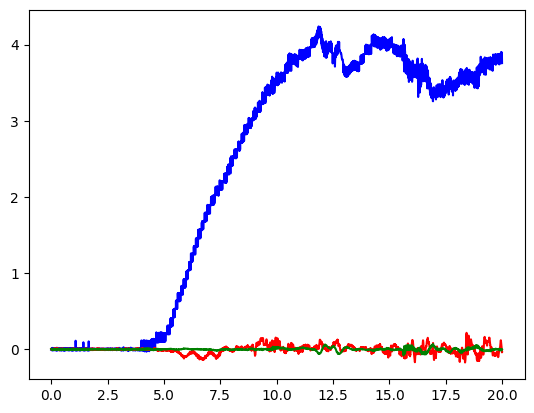

In [718]:
plt.plot(imu_times[N0:N0+N] - imu_times[N0], v_dmi[N0:N0+N, 0], 'b')
plt.plot(imu_times[N0:N0+N] - imu_times[N0], v_dmi[N0:N0+N, 1], 'r')
plt.plot(imu_times[N0:N0+N] - imu_times[N0], v_dmi[N0:N0+N, 2], 'g')

3982


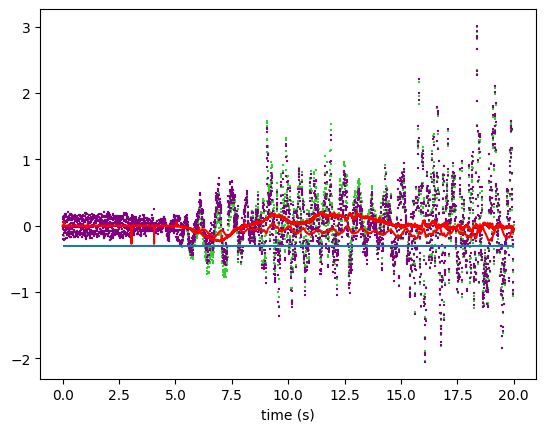

In [916]:
N = 4000

print(N0)
plt.scatter(imu_times[N0:N0+N] - imu_times[N0], accel_sbet[N0:N0+N, 1], marker='+', color='limegreen', s=2, label='ax (sbet)')
# plt.scatter(imu_times[N0:N0+N] - imu_times[N0],accel_minus_gravity[N0:N0+N, 1, 0], marker='+', color='orange', s=2, label='ax (meas)')
plt.scatter(imu_times[N0:N0+N] - imu_times[N0],sbet_accel_fd[N0:N0+N, 1], marker='+', color='purple', s=2, label='ax (fd)')

plt.plot(imu_times[N0:N0+N] - imu_times[N0],accel_sbet[N0:N0+N, 1] - sbet_accel_fd[N0:N0+N, 1], 'r')

# plt.plot(imu_times[N0:N0+N] - imu_times[N0], sbet_vels[N0:N0+N, 1], 'r')
# plt.plot(imu_times[N0:N0+N] - imu_times[N0], integ_vels[:N, 1], 'b')
# plt.plot(imu_times[N0:N0+N] - imu_times[N0], v_dmi[N0:N0+N, 0], 'g')
plt.hlines(-0.3, 0, 20)
plt.xlabel('time (s)')
plt.show()

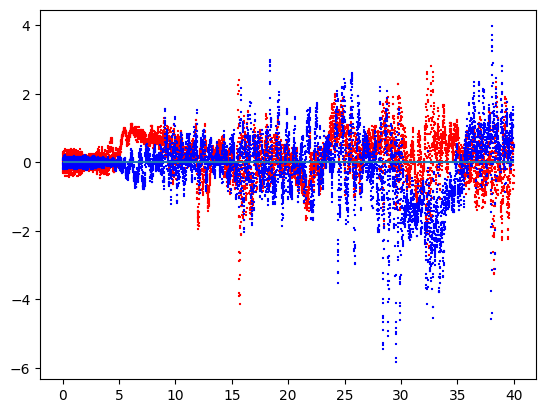

In [720]:
plt.scatter(imu_times[N0:N0+N] - imu_times[N0],accel_minus_gravity[N0:N0+N, 0], marker='+', color='red', s=2, label='ax (fd)')
plt.scatter(imu_times[N0:N0+N] - imu_times[N0],accel_minus_gravity[N0:N0+N, 1], marker='+', color='blue', s=2, label='ay (fd)')
plt.hlines(0, 0, imu_times[N+N0] - imu_times[N0])

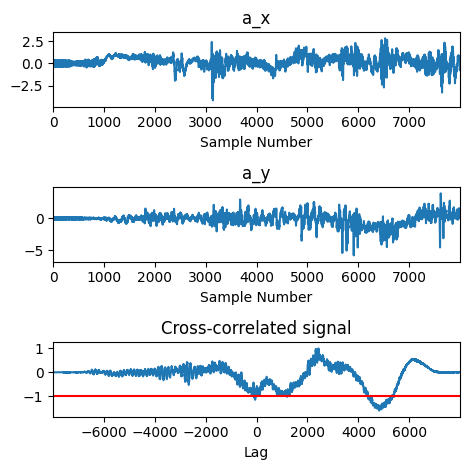

In [721]:
from scipy import signal
corr = signal.correlate(accel_minus_gravity[N0:N0+N, 1, 0], accel_minus_gravity[N0:N0+N, 0, 0])
lags = signal.correlation_lags(N, N)
corr /= np.max(corr)
fig, (ax_orig, ax_noise, ax_corr) = plt.subplots(3, 1, figsize=(4.8, 4.8))
ax_orig.plot(accel_minus_gravity[N0:N0+N, 0, 0])
ax_orig.set_title('a_x')
ax_orig.set_xlabel('Sample Number')
ax_noise.plot(accel_minus_gravity[N0:N0+N, 1, 0])
ax_noise.set_title('a_y')
ax_noise.set_xlabel('Sample Number')
ax_corr.plot(lags, corr)
ax_corr.set_title('Cross-correlated signal')
ax_corr.set_xlabel('Lag')
ax_orig.margins(0, 0.1)
ax_noise.margins(0, 0.1)
ax_corr.margins(0, 0.1)
fig.tight_layout()
ax_corr.hlines(-1, lags[0], lags[-1], 'r')
plt.show()
# plt.plot(imu_times[N0:N0+N] - imu_times[N0], corr)

In [722]:
integ_pos = []
p_prev = np.zeros(3)
integ_pos.append(p_prev)
for v in sbet_vels[N0:]:
    p = p_prev + v.squeeze() * 0.005
    integ_pos.append(p.squeeze())
    p_prev = np.copy(p)
integ_pos = np.array(integ_pos)

In [723]:
double_integ_pos = []
p_prev = np.zeros(3)
double_integ_pos.append(p_prev)
for v in integ_vels:
    p = p_prev + v.squeeze() * 0.005
    double_integ_pos.append(p.squeeze())
    p_prev = np.copy(p)
double_integ_pos = np.array(double_integ_pos)

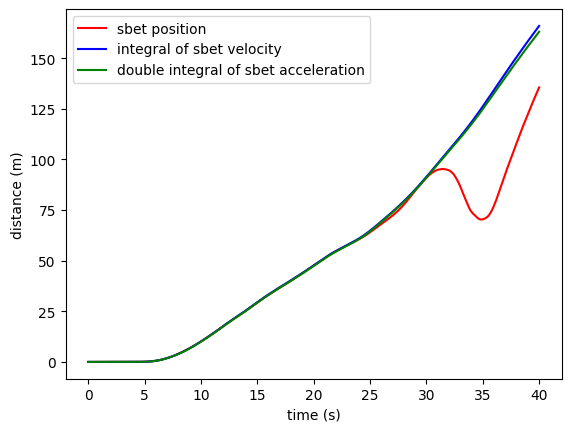

In [724]:
T_v0_0 = sbet_poses[N0]
T_0_v0 = get_inverse_tf(T_v0_0)
sbet_poses_local = []
for i in range(N0, sbet_poses.shape[0]):
    T_vk_0 = sbet_poses[i]
    T_vk_v0 = T_vk_0 @ T_0_v0
    sbet_poses_local.append(np.copy(T_vk_v0))
sbet_poses_local = np.array(sbet_poses_local)

plt.plot(imu_times[N0:N0+N] - imu_times[N0], -1 * sbet_poses_local[:N, 0, 3], 'r', label='sbet position')
plt.plot(imu_times[N0:N0+N] - imu_times[N0], integ_pos[:N, 0], 'b', label='integral of sbet velocity')
plt.plot(imu_times[N0:N0+N] - imu_times[N0], double_integ_pos[:N, 0], 'g', label='double integral of sbet acceleration')
plt.ylabel('distance (m)')
plt.xlabel('time (s)')
plt.legend()
plt.show()

In [725]:
integ_pos_global = []
p_prev = sbet_poses_global[N0, :3, 3]
integ_pos_global.append(p_prev)
for v in sbet_vels_global[N0:]:
    p = p_prev + v.squeeze() * 0.005
    integ_pos_global.append(p.squeeze())
    p_prev = np.copy(p)
integ_pos_global = np.array(integ_pos_global)

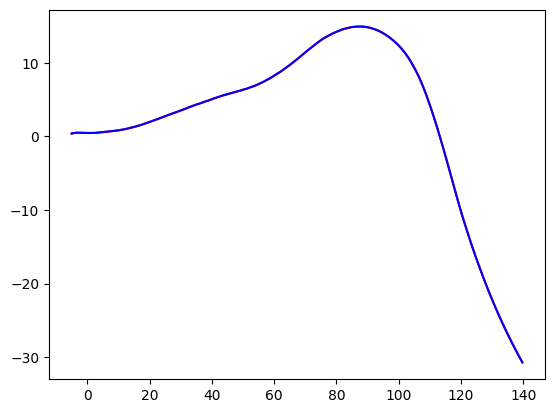

In [726]:
plt.plot(sbet_poses_global[N0:N0+N, 0, 3], sbet_poses_global[N0:N0+N, 1, 3], 'r')
plt.plot(integ_pos_global[:N, 0], integ_pos_global[:N, 1], 'b')

## Calibrate IMU Intrinsics:

In [727]:
def get_jac_e(a_gt, theta):
    jac = np.zeros((3, 9))
    jac[0, 0] = -1  # bx
    jac[1, 1] = -1  # by
    jac[2, 2] = -1  # bz
    jac[1, 3] = 1 * a_gt.squeeze()[2] * theta[7]
    jac[1, 4] = -1 * a_gt.squeeze()[0] * theta[7]
    jac[2, 5] = a_gt.squeeze()[0] * theta[8]
    jac[2, 6] = -1 * a_gt.squeeze()[1] * theta[8]
    jac[1, 7] = -1 * np.array([theta[4], 1, -theta[3]]).reshape(1, 3) @ a_gt
    jac[2, 8] = -1 * np.array([-theta[5], theta[6], 1]).reshape(1, 3) @ a_gt
    return jac

theta = np.zeros(9)  # bx,by,bz,t3,t4,t5,t6,ky,kz

P_check_inv = np.eye(9) * 1.0

for it in range(10):
    A = np.zeros((9, 9))
    b = np.zeros((9, 1))
    cost = 0.0
    
    bias = np.array(theta[:3]).reshape(3, 1)
    Tav = np.array([[1, 0, 0],[theta[4], 1, -theta[3]],[-theta[5], theta[6], 1]])
    K = np.eye(3)
    K[1, 1] = theta[7]
    K[2, 2] = theta[8]
    for i in range(N0, imu_data.shape[0]):
        ebar = sbet_accel_fd[i, :].reshape(3, 1) - K @ Tav @ accel_sbet[i, :].reshape(3, 1) - bias
        cost += ebar.T @ ebar
        G = get_jac_e(accel_sbet[i, :], theta)
        A += G.T @ G
        b += -1 * G.T @ ebar
    A += P_check_inv
    b += P_check_inv @ theta.reshape(9, 1)
    dtheta = npla.solve(A, b).squeeze()
    theta += dtheta
    print('cost: {} dtheta: {} theta: {}'.format(cost.item(), dtheta.squeeze(), theta.squeeze()))

cost: 271284.6642087177 dtheta: [0.00506888 0.01411227 0.00766059 0.         0.         0.
 0.         0.55810506 0.99781019] theta: [0.00506888 0.01411227 0.00766059 0.         0.         0.
 0.         0.55810506 0.99781019]
cost: 76672.69346165915 dtheta: [ 4.81060092e-08 -3.17519970e-05 -1.00859579e-04 -2.00055230e-02
 -4.32669357e-02  2.70675314e-02  2.20623871e-03  1.91330134e-04
 -2.56847600e-03] theta: [ 0.00506893  0.01408052  0.00755973 -0.02000552 -0.04326694  0.02706753
  0.00220624  0.55829639  0.99524171]
cost: 76294.37701456464 dtheta: [ 4.56543038e-13  2.71362003e-10 -1.83248046e-09  5.96555579e-06
  1.38419893e-05  7.00608721e-05  5.71980063e-06 -1.79278927e-08
 -6.46128152e-08] theta: [ 0.00506893  0.01408052  0.00755973 -0.01999956 -0.04325309  0.02713759
  0.00221196  0.55829637  0.99524165]
cost: 76294.37567715708 dtheta: [ 9.21949988e-18  2.28810346e-13 -1.75023898e-12  2.64655747e-10
  3.17318913e-10  5.34372126e-10  6.66120833e-11  1.83348517e-11
 -9.58109074e-1

In [728]:
# Check Jacobian of IMU intrinsic calibration
print(ebar)
theta = np.array([0.01, 0.01, 0.01, 0.03, 0.04, 0.05, 0.06, 1.01, 1.02])
bias = np.array(theta[:3]).reshape(3, 1)
Tav = np.array([[1, 0, 0],[theta[4], 1, -theta[3]],[-theta[5], theta[6], 1]])
K = np.eye(3)
K[1, 1] = theta[7]
K[2, 2] = theta[8]
ebar = sbet_accel_fd[i, :].reshape(3, 1) - Tav @ accel_sbet[i, :].reshape(3, 1) - bias
# print(G)
G = get_jac_e(accel_sbet[i, :], theta)
eps = 1.0e-3
num_jac = np.zeros((3, 9))
for j in range(9):
    delta = np.zeros(9)
    delta[j] = eps
    theta2 = theta + delta
    theta1 = theta - delta
    bias1 = np.array(theta1[:3]).reshape(3, 1)
    Tav1 = np.array([[1, 0, 0],[theta1[4], 1, -theta1[3]],[-theta1[5], theta1[6], 1]])
    K1 = np.eye(3)
    K1[1, 1] = theta1[7]
    K1[2, 2] = theta1[8]
    bias2 = np.array(theta2[:3]).reshape(3, 1)
    Tav2 = np.array([[1, 0, 0],[theta2[4], 1, -theta2[3]],[-theta2[5], theta2[6], 1]])
    K2 = np.eye(3)
    K2[1, 1] = theta2[7]
    K2[2, 2] = theta2[8]
    e1 = sbet_accel_fd[i, :].reshape(3, 1) - K1 @ Tav1 @ accel_sbet[i, :].reshape(3, 1) - bias1
    e2 = sbet_accel_fd[i, :].reshape(3, 1) - K2 @ Tav2 @ accel_sbet[i, :].reshape(3, 1) - bias2
    num_jac[:, j] = ((e2 - e1) / (2 * eps)).squeeze()
    
print(G)
print(num_jac)

print(npla.norm(G - num_jac))

[[-0.00484411]
 [-0.01460138]
 [-0.01087784]]
[[-1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00 -1.00000000e+00  0.00000000e+00  6.47382461e-02
   1.36350805e-01  0.00000000e+00  0.00000000e+00 -1.38931412e-04
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00  0.00000000e+00
   0.00000000e+00 -1.37700813e-01 -7.61111914e-03  0.00000000e+00
  -7.12950261e-02]]
[[-1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00 -1.00000000e+00  0.00000000e+00  6.47382461e-02
   1.36350805e-01  0.00000000e+00  0.00000000e+00 -1.38931412e-04
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00  0.00000000e+00
   0.00000000e+00 -1.37700813e-01 -7.61111914e-03  0.00000000e+00
  -7.12950261e-02]]
1.1570079788736297e-14


In [729]:
theta = np.array([ 0.00506893,  0.01408052,  0.00755973, -0.01999956, -0.04325309,  0.02713759,  0.00221196,  0.55829637,  0.99524165])
bias = np.array(theta[:3]).reshape(3, 1)
Tav = np.array([[1, 0, 0],[theta[4], 1, -theta[3]],[-theta[5], theta[6], 1]])
K = np.eye(3)
K[1, 1] = theta[7]
K[2, 2] = theta[8]
accel_sbet_calibrated = []
for i in range(accel_sbet.shape[0]):
    a = accel_sbet[i, :].reshape(3, 1)
    acalib = K @ Tav @ a.reshape(3, 1) + bias
    accel_sbet_calibrated.append(acalib.squeeze())
accel_sbet_calibrated = np.array(accel_sbet_calibrated)

In [730]:
integ_vels_calibrated = []
v_prev = np.zeros(3)
integ_vels_calibrated.append(v_prev)
for a in accel_sbet_calibrated[N0:]:
    v = v_prev + a.squeeze() * 0.005
    integ_vels_calibrated.append(v.squeeze())
    v_prev = np.copy(v)
integ_vels_calibrated = np.array(integ_vels_calibrated)

3982


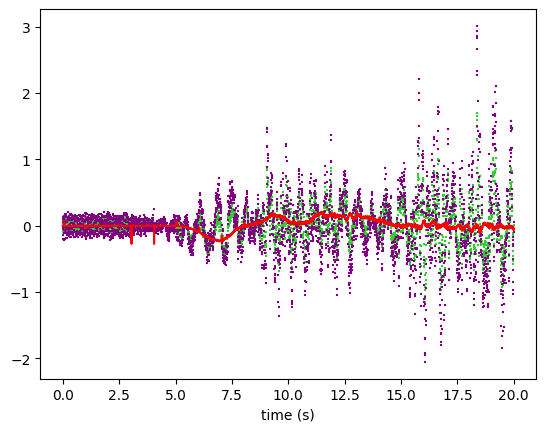

In [813]:
N = 4000

print(N0)
plt.scatter(imu_times[N0:N0+N] - imu_times[N0], accel_sbet_calibrated[N0:N0+N, 1], marker='+', color='limegreen', s=2, label='ax (sbet)')
# plt.scatter(imu_times[N0:N0+N] - imu_times[N0],accel_minus_gravity[N0:N0+N, 1, 0], marker='+', color='orange', s=2, label='ax (meas)')
plt.scatter(imu_times[N0:N0+N] - imu_times[N0],sbet_accel_fd[N0:N0+N, 1], marker='+', color='purple', s=2, label='ax (fd)')

plt.plot(imu_times[N0:N0+N] - imu_times[N0],accel_sbet[N0:N0+N, 1] - sbet_accel_fd[N0:N0+N, 1], 'r')

# plt.plot(imu_times[N0:N0+N] - imu_times[N0], sbet_vels[N0:N0+N, 1], 'r')
# plt.plot(imu_times[N0:N0+N] - imu_times[N0], integ_vels_calibrated[:N, 1], 'b')
# plt.plot(imu_times[N0:N0+N] - imu_times[N0], v_dmi[N0:N0+N, 0], 'g')
# plt.hlines(-0.65 * 0.15, 0, 20)
plt.xlabel('time (s)')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


accel:
std: [4.41535553 4.41508525 4.41522756]
cov: [19.4953645  19.49297776 19.49423443]
ang vel:
std: [0.35619219 0.35625371 0.35652225]
cov: [0.12687288 0.12691671 0.12710811]


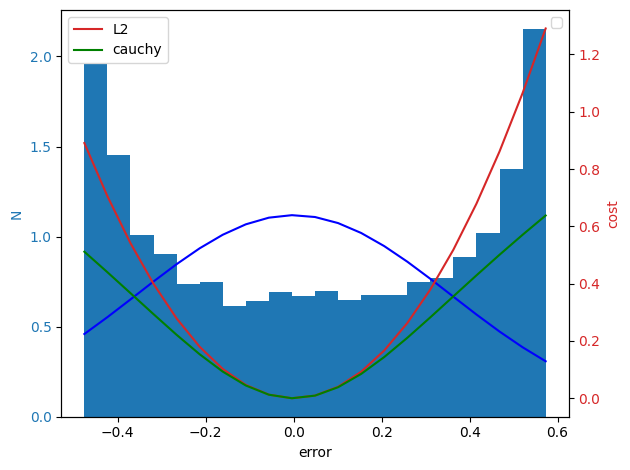

In [109]:
print('accel:')
# print(np.std(accel_minus_gravity[:1000].squeeze()**2, axis=0))

# e = accel_minus_gravity.squeeze() - accel_sbet
# acc_std = np.std(e, axis=0)
# acc_cov = acc_std**2

acc_cov = np.mean((accel_minus_gravity[:4000]**2).squeeze(), axis=0)
acc_std = np.sqrt(acc_cov)
print('std: {}'.format(acc_std))
print('cov: {}'.format(acc_cov))
# print(np.sqrt(np.mean((accel_minus_gravity[:1000]**2).squeeze()**2, axis=0)))
print('ang vel:')
ang_cov = np.mean((imu_data[:4000, 3:]**2).squeeze(), axis=0)
# ang_cov = np.array([0.04898588, 0.06860401, 0.04319808])
ang_std = np.sqrt(ang_cov)
print('std: {}'.format(ang_std))
print('cov: {}'.format(ang_cov))

def gaussian(x, mu=0, sigma=1.0):
    return (1 / (sigma * np.sqrt( 2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2)

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('error')
ax1.set_ylabel('N', color=color)
dim = 5
N = 20
_, bins, _ = ax1.hist(imu_data[:4000, dim], bins=20, density=True)
ax1.tick_params(axis='y', labelcolor=color)
ax1.plot(bins, gaussian(bins, mu=0, sigma=ang_std[dim - 3]), color='b')
# ax1.vlines(ang_std[dim - 3], ymin=0, ymax=2, colors='r', label='1-sigma')
ax1.legend()

bins = np.array(bins)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('cost', color=color)
e = np.sqrt(bins**2 / ang_cov[dim - 3])
L2 = 0.5 * (e**2)
ax2.plot(bins, L2, color=color, label='L2')
k = 1.0
cauchy = (k**2 / 2) * np.log(1 + (e / k)**2)
ax2.plot(bins, cauchy, color='g', label='cauchy')

ax2.tick_params(axis='y', labelcolor=color)
ax2.legend()

fig.tight_layout()
# _, bins, _ = plt.hist(accel_minus_gravity[:1000, 0], bins=20)

# plt.plot(bins, L2, 'r')
# plt.
# plt.hist(imu_data[:1000, 1], bins=20)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


accel:
std: [4.41535553 4.41508525 4.41522756]
cov: [19.4953645  19.49297776 19.49423443]
ang vel:
std: [0.35619219 0.35625371 0.35652225]
cov: [0.12687288 0.12691671 0.12710811]


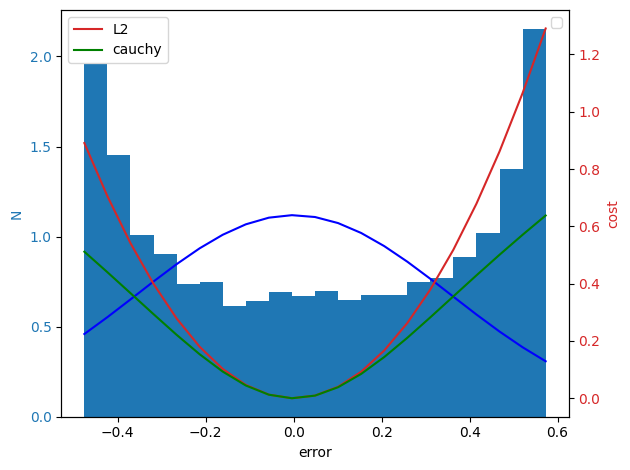

In [110]:
print('accel:')
# print(np.std(accel_minus_gravity[:1000].squeeze()**2, axis=0))

# e = accel_minus_gravity.squeeze() - accel_sbet
# acc_std = np.std(e, axis=0)
# acc_cov = acc_std**2

acc_cov = np.mean((accel_minus_gravity[:4000]**2).squeeze(), axis=0)
acc_std = np.sqrt(acc_cov)
print('std: {}'.format(acc_std))
print('cov: {}'.format(acc_cov))
# print(np.sqrt(np.mean((accel_minus_gravity[:1000]**2).squeeze()**2, axis=0)))
print('ang vel:')
ang_cov = np.mean((imu_data[:4000, 3:]**2).squeeze(), axis=0)
# ang_cov = np.array([0.04898588, 0.06860401, 0.04319808])
ang_std = np.sqrt(ang_cov)
print('std: {}'.format(ang_std))
print('cov: {}'.format(ang_cov))

def gaussian(x, mu=0, sigma=1.0):
    return (1 / (sigma * np.sqrt( 2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2)

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('error')
ax1.set_ylabel('N', color=color)
dim = 5
N = 20
_, bins, _ = ax1.hist(imu_data[:4000, dim], bins=20, density=True)
ax1.tick_params(axis='y', labelcolor=color)
ax1.plot(bins, gaussian(bins, mu=0, sigma=ang_std[dim - 3]), color='b')
# ax1.vlines(ang_std[dim - 3], ymin=0, ymax=2, colors='r', label='1-sigma')
ax1.legend()

bins = np.array(bins)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('cost', color=color)
e = np.sqrt(bins**2 / ang_cov[dim - 3])
L2 = 0.5 * (e**2)
ax2.plot(bins, L2, color=color, label='L2')
k = 1.0
cauchy = (k**2 / 2) * np.log(1 + (e / k)**2)
ax2.plot(bins, cauchy, color='g', label='cauchy')

ax2.tick_params(axis='y', labelcolor=color)
ax2.legend()

fig.tight_layout()
# _, bins, _ = plt.hist(accel_minus_gravity[:1000, 0], bins=20)

# plt.plot(bins, L2, 'r')
# plt.
# plt.hist(imu_data[:1000, 1], bins=20)
plt.show()

## Estimated States
data: T(4,4), w(6), dw(6), b(6), cov(18,18)

In [517]:
if sensor == 'radar':
    T_robot_sensor2 = T_yfwd2xfwd @ T_applanix_sensor @ zup2zdown
    T_sensor_robot2 = get_inverse_tf(T_robot_sensor2)
else:
    T_robot_sensor2 = T_yfwd2xfwd @ T_applanix_sensor
    T_sensor_robot2 = get_inverse_tf(T_robot_sensor2)

data = []
with open(debug_path) as f:
    for line in f.readlines():
        data.append([float(x) for x in line.rstrip().split()])
# data = data[:len(data) // 2]
data = np.array(data)
poses = []  # T_ms
vels = []  # w_rm_ins
accels = []  # dw_rm_ins
biases = []  # bias on accel meas in robot frame
covs = []  # cov on pos, w, dw
T_mis = []
xi_mis = []
rpys = []
for i in range(data.shape[0]):
    T = data[i, :16].reshape(4, 4) @ T_sensor_robot2
    poses.append(T)
    vels.append(-1 * data[i, 16:22])
    accels.append(-1 * data[i, 22:28])
    biases.append(data[i, 28: 34])
    covs.append(data[i, 34:34+18*18].reshape(18, 18))
    T_mi_ = data[i, -16:].reshape(4, 4)
    T_mis.append(T_mi_)
    xi_mis.append(se3op.tran2vec(T_mi_)[-3:].squeeze())
    rpys.append(rotToYawPitchRoll(T[:3, :3])[::-1])

poses = np.array(poses)
vels = np.array(vels)
accels = np.array(accels)
covs = np.array(covs)
biases = np.array(biases)
rpys = np.array(rpys)
T_mis = np.array(T_mis)
xi_mis = np.array(xi_mis)

## Visualize Debug States

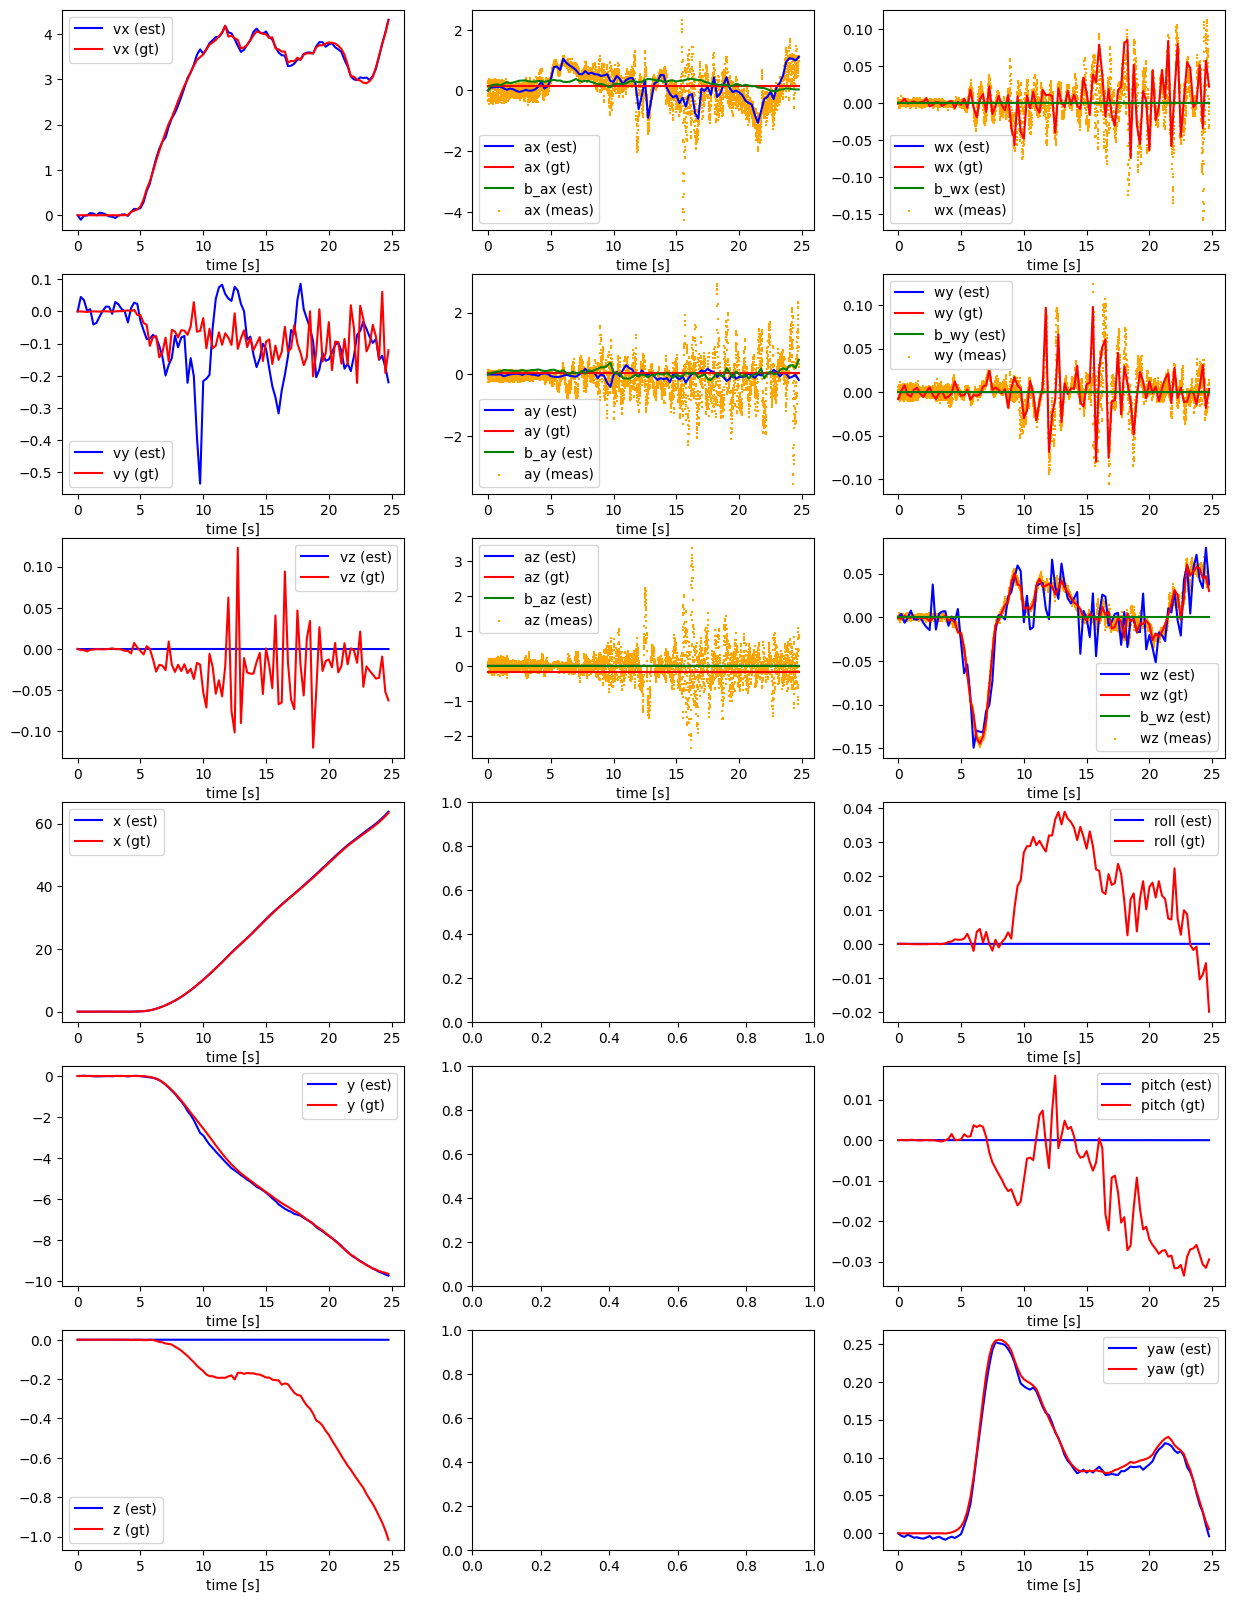

In [518]:
N = poses.shape[0]
N = 100
times = np.copy(times_gt[:N])
t0 = times[0]
tN = times[-1]
imu_plot = []
imu_plot_times = []
accel_minus_plot = []
for i in range(imu_data.shape[0]):
    if t0 <= imu_times[i] <= tN:
        imu_plot.append(imu_data[i, :])
        imu_plot_times.append(imu_times[i])
        accel_minus_plot.append(accel_minus_gravity[i, :])
imu_plot = np.array(imu_plot)
imu_plot_times = np.array(imu_plot_times)
accel_minus_plot = np.array(accel_minus_plot)
imu_plot_times -= t0
times -= t0
fig, axs = plt.subplots(6, 3, figsize=(15, 20))

# bodyframe linear velocity
axs[0, 0].plot(times, vels[:N, 0], 'b', label='vx (est)')
axs[0, 0].plot(times, vels_gt[:N, 0], 'r', label='vx (gt)')
axs[0, 0].set_xlabel('time [s]')
axs[0, 0].legend()
axs[1, 0].plot(times, vels[:N, 1], 'b', label='vy (est)')
axs[1, 0].plot(times, vels_gt[:N, 1], 'r', label='vy (gt)')
axs[1, 0].set_xlabel('time [s]')
axs[1, 0].legend()
axs[2, 0].plot(times, vels[:N, 2], 'b', label='vz (est)')
axs[2, 0].plot(times, vels_gt[:N, 2], 'r', label='vz (gt)')
axs[2, 0].set_xlabel('time [s]')
axs[2, 0].legend()

# body frame linear acceleration
axs[0, 1].plot(times, accels[:N, 0], 'b', label='ax (est)')
axs[0, 1].plot(times, accels_gt[:N, 0], 'r', label='ax (gt)')
axs[0, 1].plot(times, biases[:N, 0], 'g', label='b_ax (est)')
axs[0, 1].scatter(imu_plot_times, accel_minus_plot[:, 0], marker='+', color='orange', s=2, label='ax (meas)')
axs[0, 1].set_xlabel('time [s]')
axs[0, 1].legend()
axs[1, 1].plot(times, accels[:N, 1], 'b', label='ay (est)')
axs[1, 1].plot(times, accels_gt[:N, 1], 'r', label='ay (gt)')
axs[1, 1].plot(times, biases[:N, 1], 'g', label='b_ay (est)')
axs[1, 1].scatter(imu_plot_times, accel_minus_plot[:, 1], marker='+', color='orange', s=2, label='ay (meas)')
axs[1, 1].set_xlabel('time [s]')
axs[1, 1].legend()
axs[2, 1].plot(times, accels[:N, 2], 'b', label='az (est)')
axs[2, 1].plot(times, accels_gt[:N, 2], 'r', label='az (gt)')
axs[2, 1].plot(times, biases[:N, 2], 'g', label='b_az (est)')
axs[2, 1].scatter(imu_plot_times, accel_minus_plot[:, 2], marker='+', color='orange', s=2, label='az (meas)')
axs[2, 1].set_xlabel('time [s]')
axs[2, 1].legend()

# body frame angular velocity
axs[0, 2].plot(times, vels[:N, 3], 'b', label='wx (est)')
axs[0, 2].plot(times, vels_gt[:N, 3], 'r', label='wx (gt)')
axs[0, 2].plot(times, biases[:N, 3], 'g', label='b_wx (est)')
axs[0, 2].scatter(imu_plot_times, imu_plot[:, 3], marker='+', color='orange', s=2, label='wx (meas)')
axs[0, 2].set_xlabel('time [s]')
axs[0, 2].legend()
axs[1, 2].plot(times, vels[:N, 4], 'b', label='wy (est)')
axs[1, 2].plot(times, vels_gt[:N, 4], 'r', label='wy (gt)')
axs[1, 2].plot(times, biases[:N, 4], 'g', label='b_wy (est)')
axs[1, 2].scatter(imu_plot_times, imu_plot[:, 4], marker='+', color='orange', s=2, label='wy (meas)')
axs[1, 2].set_xlabel('time [s]')
axs[1, 2].legend()
axs[2, 2].plot(times, vels[:N, 5], 'b', label='wz (est)')
axs[2, 2].plot(times, vels_gt[:N, 5], 'r', label='wz (gt)')
axs[2, 2].plot(times, biases[:N, 5], 'g', label='b_wz (est)')
axs[2, 2].scatter(imu_plot_times, imu_plot[:, 5], marker='+', color='orange', s=2, label='wz (meas)')
axs[2, 2].set_xlabel('time [s]')
axs[2, 2].legend()

# position relative to the map frame
axs[3, 0].plot(times, poses[:N, 0, 3], 'b', label='x (est)')
axs[3, 0].plot(times, poses_gt[:N, 0, 3], 'r', label='x (gt)')
axs[3, 0].set_xlabel('time [s]')
axs[3, 0].legend()
axs[4, 0].plot(times, poses[:N, 1, 3], 'b', label='y (est)')
axs[4, 0].plot(times, poses_gt[:N, 1, 3], 'r', label='y (gt)')
axs[4, 0].set_xlabel('time [s]')
axs[4, 0].legend()
axs[5, 0].plot(times, poses[:N, 2, 3], 'b', label='z (est)')
axs[5, 0].plot(times, poses_gt[:N, 2, 3], 'r', label='z (gt)')
axs[5, 0].set_xlabel('time [s]')
axs[5, 0].legend()

# orientation relative to the map frame
axs[3, 2].plot(times, rpys[:N, 0], 'b', label='roll (est)')
axs[3, 2].plot(times, rpys_gt[:N, 0], 'r', label='roll (gt)')
axs[3, 2].set_xlabel('time [s]')
axs[3, 2].legend()
axs[4, 2].plot(times, rpys[:N, 1], 'b', label='pitch (est)')
axs[4, 2].plot(times, rpys_gt[:N, 1], 'r', label='pitch (gt)')
axs[4, 2].set_xlabel('time [s]')
axs[4, 2].legend()
axs[5, 2].plot(times, rpys[:N, 2], 'b', label='yaw (est)')
axs[5, 2].plot(times, rpys_gt[:N, 2], 'r', label='yaw (gt)')
axs[5, 2].set_xlabel('time [s]')
axs[5, 2].legend()

plt.show()

In [460]:
N = poses.shape[0]
accel_fd = []
for i in range(1, vels_gt.shape[0] - 1):
    accel_fd.append((vels_gt[i + 1, :] - vels_gt[i - 1, :]) / (times_gt[i + 1] - times_gt[i - 1]))
accel_fd = np.array(accel_fd)

# N = poses.shape[0]
# N = 100


plt.plot(times, accels_gt[:N, 0], 'r', label='ay (gt)')
plt.plot(times, accels[:N, 0], 'b', label='ay (est)')false
# plt.plot(times, biases[:, 1], 'g', label='b_ay (est)')
# plt.plot(times[1:], accel_fd[:N-1, 1], 'limegreen', label='ay_fd')
# plt.scatter(imu_plot_times, accel_minus_plot[:, 1], marker='+', color='orange', s=2, label='ay (meas)')

plt.xlabel('time [s]')
plt.legend()

plt.show()false

SyntaxError: invalid syntax (1244694471.py, line 12)

In [377]:
# N = 200

N0 = int((times_gt[0] - sbet_times[0]) / 0.005)
N = poses.shape[0] * 20
plt.plot(imu_times[N0:N0+N] - imu_times[N0],accel_sbet[N0:N0+N, 1] - sbet_accel_fd[N0:N0+N, 1], 'purple')


N = poses.shape[0]
# plt.plot(times, biases[:N, 0], label='b_ax', color='r')
plt.plot(times, biases[:N, 1], label='b_ay', color='g')
# plt.plot(times, biases[:N, 2], label='b_az', color='b')

# plt.hlines(y=bias_gt[0], xmin=times[0], xmax=times[-1], color='r', linestyle='--')
# plt.hlines(y=bias_gt[1], xmin=times[0], xmax=times[-1], color='g', linestyle='--')
# plt.hlines(y=bias_gt[2], xmin=times[0], xmax=times[-1], color='b', linestyle='--')
plt.legend()
plt.show()

IndexError: index -1502348086 is out of bounds for axis 0 with size 214719

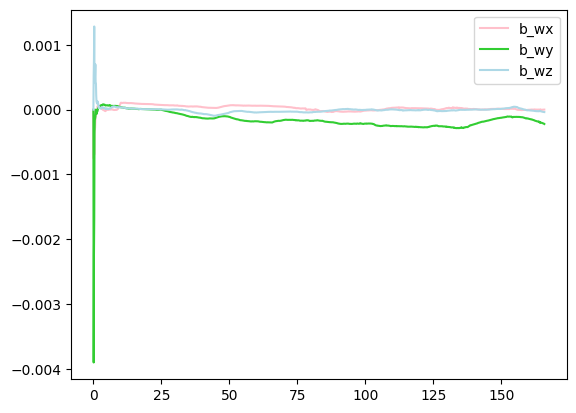

In [293]:
N = poses.shape[0]
plt.plot(times, biases[:N, 3], label='b_wx', color='pink')
plt.plot(times, biases[:N, 4], label='b_wy', color='limegreen')
plt.plot(times, biases[:N, 5], label='b_wz', color='lightblue')
# plt.hlines(y=bias_gt[3], xmin=times[0], xmax=times[-1], color='pink', linestyle='--')
# plt.hlines(y=bias_gt[4], xmin=times[0], xmax=times[-1], color='limegreen', linestyle='--')
# plt.hlines(y=bias_gt[5], xmin=times[0], xmax=times[-1], color='lightblue', linestyle='--')
plt.legend()
plt.show()

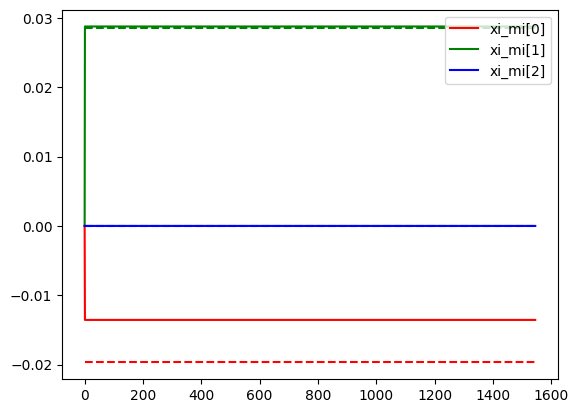

In [245]:
plt.plot(xi_mis[:, 0], label='xi_mi[0]', color='r')
plt.plot(xi_mis[:, 1], label='xi_mi[1]', color='g')
plt.plot(xi_mis[:, 2], label='xi_mi[2]', color='b')
plt.hlines(y=xi_ig_gt[0], xmin=0, xmax=xi_mis.shape[0], color='r', linestyle='--')
plt.hlines(y=xi_ig_gt[1], xmin=0, xmax=xi_mis.shape[0], color='g', linestyle='--')
plt.hlines(y=xi_ig_gt[2], xmin=0, xmax=xi_mis.shape[0], color='b', linestyle='--')
plt.legend()
plt.show()

In [154]:
def sym(A: np.ndarray) -> np.ndarray:
    return A + A.T - A * np.eye(A.shape[0])

In [ ]:
import os.path as osp
import struct
from datetime import datetime
from pylgmath import se3op

import matplotlib.pyplot as plt

from estimate_qc import *

In [ ]:
poses = poses_gt
vels = vels_gt[:, :3]
ang_vels = vels_gt[:, 3:]
accels = accels_gt[:, :3]
dim = 6
dt = 0.1
ang_accels = []
w_prev = np.zeros((3, 1))
# for w in ang_vels:
for i in range(ang_vels.shape[0]):
    w = ang_vels[i, :].reshape(3, 1)
    wa = (w - w_prev) / dt
    ang_accels.append(wa.squeeze())
    w_prev = np.copy(w)
ang_accels = np.array(ang_accels)

In [ ]:
print(poses.shape)

In [ ]:
imu_body_raw_to_applanix = np.array([0, -1, 0, -1, 0, 0, 0, 0, -1]).reshape(3, 3)
dim = 6
gamma1 = []
gamma2 = []
biases = []
t = 0
for i in range(poses.shape[1]):
    if i < poses.shape[1] - 1:
        g1 = np.zeros((dim * 3, 1))
        g2 = np.zeros((dim * 3, 1))
        g1[6 : 9] = vels[i].reshape(3, 1)
        g1[9 : 12] = ang_vels[i].reshape(3, 1)
        g1[12 : 15] = accels[i].reshape(3, 1)
        g1[15 : 18] = ang_accels[i].reshape(3, 1)
        xi_21 = se3op.tran2vec(poses[i + 1] @ get_inverse_tf(poses[i]))
        g2[:6] = xi_21
        J_21_inv = se3op.vec2jacinv(xi_21)
        w2 = np.array([vels[i + 1], ang_vels[i + 1]]).reshape(6, 1)
        temp = J_21_inv @ w2
        g2[6 : 12] = temp
        dw2 = np.array([accels[i + 1], ang_accels[i + 1]]).reshape(6, 1)
        g2[12 : 18] = -0.5 * se3op.curlyhat(temp) @ w2 + J_21_inv @ dw2
        gamma1.append(g1)
        gamma2.append(g2)
        
        # C_vi = poses[0, i, :3, :3]
        # a_raw = imu_body_raw_to_applanix @ imu_raw[i, [5,4,3]].reshape(3, 1)
        # a = accels[0, i + 1].reshape(3, 1)
        # biases.append(a_raw - a + C_vi @ np.array([0, 0, -9.8042]).reshape(3, 1))
gamma1 = np.expand_dims(np.array(gamma1), axis=0)
gamma2 = np.expand_dims(np.array(gamma2), axis=0)
biases = np.expand_dims(np.array(biases), axis=0)

In [ ]:
include_bias = False
qc = np.ones(dim)
ad = np.array([0, 0, 0, 100, 100, 100])
qb = np.ones(3)

lr = 1.0
params = []
costs = []
lrs = []
N = 1000
ad_prev = np.copy(ad)
qc_prev = np.copy(qc)
cost_prev = 0.0
cost_init = False

for it in range(N):
    params.append([qc, ad])
    Delta_k = get_q_singer(dt, ad, np.ones(dim))
    Delta_k_inv = npla.inv(Delta_k)
    dQk_da = get_jac_Qk_alpha(dt, ad, qc)
    dQk_dsigma = get_jac_Qk_sigma(qc)
    for j in range(dim):
        if ad[j] < 0.05:
            dQk_da[j] = np.zeros((3 * dim, 3 * dim))
    Phi = get_tran_singer(dt, ad)
    Qk = get_q_singer(dt, ad, qc)
    Qk_inv = npla.inv(Qk)
    Qbk = np.diag(qb) * dt
    Qbk_inv = npla.inv(Qbk)
    
    jac_ad = np.zeros(dim)
    cost = 0
    K = gamma1.shape[1]
    t = 0
    T = 1
    
    # for t in range(states_all.shape[0]):
    jac_ad_tmp = np.zeros(dim)
    s = np.zeros(dim)
    for i in range(K):
        ek = gamma2[t, i].reshape(-1, 1) - Phi @ gamma1[t, i].reshape(-1, 1)
        if include_bias:
            ebk = biases[t, i + 1] - biases[t, i]
            # ek = np.vstack((ek, ebk))
            # Qk_inv = np.block([[Qk_inv, np.zeros((3, 3))],[np.zeros((3, 3)), Qbk_inv]])
        cost += ek.T @ Qk_inv @ ek
        dek_da = get_jac_ek_alpha(dt, ad, gamma1[t, i].reshape(-1, 1))
        # if include_bias:
        #     dek_da = np.vstack((dek_da, np.zeros((3, 1))))
        for j in range(dim):
            if ad[j] >= 0.05:
                jac_ad_tmp[j] += -0.5 * np.trace(sym(ek @ ek.T) @ Qk_inv @ dQk_da[j] @ Qk_inv)
                jac_ad_tmp[j] += ek.T @ Qk_inv @ dek_da[j]
            s[j] += ek.T @ Delta_k_inv @ dQk_dsigma[j] @ ek
    for j in range(dim):
        if ad[j] >= 0.05:
            jac_ad[j] += jac_ad_tmp[j] / K + 0.5 * np.trace(Qk_inv @ dQk_da[j])
    cost += K * np.log(npla.det(Qk))
    jac_ad /= T
    cost /= T
    print("cost: {:10.4f} qc: {} jac_ad: {} ad: {}".format(cost.item(), qc, jac_ad, ad))
    qc = s / (3 * K * T)
    # if it > 0:
        # ad = ad - lr * jac_ad
    for j in range(ad.shape[0]):
        if ad[j] < 0.05:
            ad[j] = 0.0
            jac_ad[j] = 0.0
    costs.append(cost.item())

    if np.linalg.norm(ad - ad_prev) < 1.0e-3 and np.linalg.norm(qc - qc_prev) < 1.0e-3:
        print("Parameters converged!")
        break

    if cost.item() - cost_prev > 0 and cost_init is True:
        print("Min cost reached")
        break

    ad_prev = ad
    qc_prev = qc
    cost_prev = cost.item()
    cost_init = True

params = np.array(params)